In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import zscore
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import gaussian_filter1d

In [2]:
df = pd.read_csv('CSV_Files/Ledger_Metadata_2024-11-30.csv')

df = df[['Ledger_Number', 'Row_Count']]

df['Ledger_Number_Scaled'] = (df['Ledger_Number'] // 500)
df['Ledger_Number_Scaled'] -= df['Ledger_Number_Scaled'].min()

df.sort_values(by='Ledger_Number_Scaled')
df.head()

,Ledger_Number,Row_Count,Ledger_Number_Scaled
0,89899995,32,0
1,89900495,27,1
2,89900995,26,2
3,89901495,45,3
4,89901995,31,4


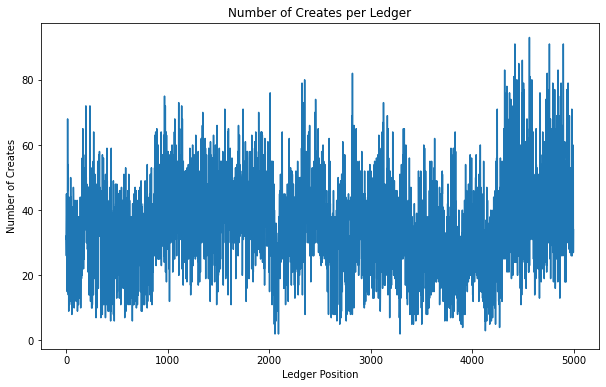

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df['Ledger_Number_Scaled'], df['Row_Count'])

plt.xlabel('Ledger Position')
plt.ylabel('Number of Creates')
plt.title('Number of Creates per Ledger')

plt.show()

## No visible relationship any which way, possible high variance
## What about creates related to XRP?

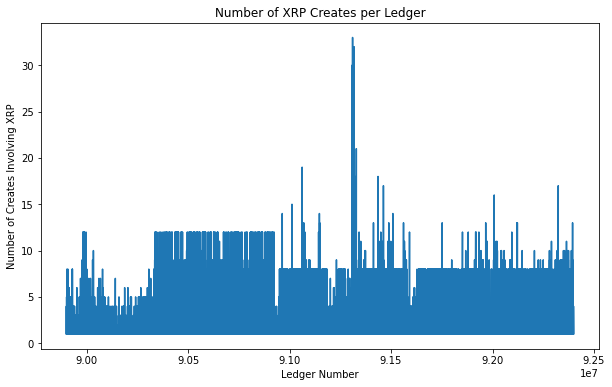

In [4]:
df = pd.read_csv('CSV_Files/Ledger_Currency_Pairs_2024-11-30.csv')
df_xrp = df[(df['Gets_Currency_Code'] == 'XRP') | (df['Pays_Currency_Code'] == 'XRP')]
df_xrp_grouped = df_xrp.groupby(['Ledger_Number', 'Ledger_Date']).agg(
    Row_Count=('Row_Count', 'sum')
).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df['Ledger_Number'], df['Row_Count'])

plt.xlabel('Ledger Number')
plt.ylabel('Number of Creates Involving XRP')
plt.title('Number of XRP Creates per Ledger')

plt.show()

## Findings: Once again no visible relationship, could be worth investingating small section with high outliers
## What about the amount of XRP related in these trades over 500 block intervals?

In [5]:
# Build transformation function
def transform_row(row):
    if row['Gets_Currency_Code'] == 'XRP':
        return {
            'Ledger_Number': row['Ledger_Number'],
            'Datetime': row['Ledger_Date'],

            'XRP_Code': row['Gets_Currency_Code'],
            'XRP_Amount': row['Gets_Count_sum'],

            'Trade_Code': row['Pays_Currency_Code'],
            'Code_Amount': row['Pays_Count_sum']
        }
    
    elif row['Pays_Currency_Code'] == 'XRP':
        return {
            'Ledger_Number': row['Ledger_Number'],
            'Datetime': row['Ledger_Date'],

            'XRP_Code': row['Pays_Currency_Code'],
            'XRP_Amount': row['Pays_Count_sum'],

            'Trade_Code': row['Gets_Currency_Code'],
            'Code_Amount': row['Gets_Count_sum']
        }
    else:
        print('Error')
        raise ValueError('Invalid row entry')


transformed_data = [transform_row(row) for _, row in df_xrp.iterrows()]
df_xrp = pd.DataFrame(transformed_data)

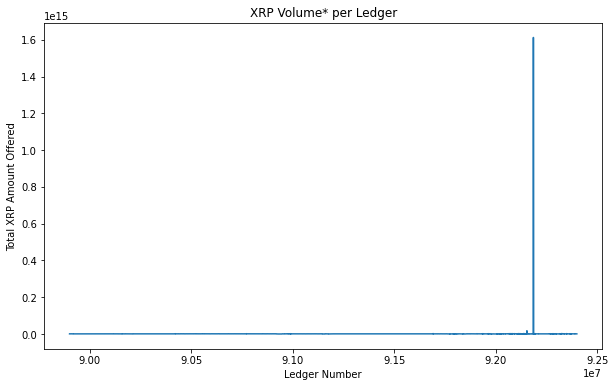

In [6]:
df_xrp_only = df_xrp.groupby(['Ledger_Number', 'Datetime', 'XRP_Code']).agg(
    XRP_Amount=('XRP_Amount', 'sum')
).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_xrp_only['Ledger_Number'], df_xrp_only['XRP_Amount'])

plt.xlabel('Ledger Number')
plt.ylabel('Total XRP Amount Offered')
plt.title('XRP Volume* per Ledger')

plt.show()

### Find and Remove extreme outliers

In [7]:
df_xrp_only['z_score'] = zscore(df_xrp_only['XRP_Amount'], nan_policy='omit')
df_xrp_only.sort_values(by='z_score', ascending=False).head(10)


,Ledger_Number,Datetime,XRP_Code,XRP_Amount,z_score
4554,92185495,2024-11-18T05:17:12.000Z,XRP,1.612689e+15,70.567375
4490,92153495,2024-11-16T18:16:22.000Z,XRP,1.745907e+13,0.720496
4456,92136495,2024-11-15T23:38:50.000Z,XRP,2.354971e+12,0.059165
4835,92325995,2024-11-24T14:42:40.000Z,XRP,2.317040e+12,0.057504
4325,92070995,2024-11-13T00:14:02.000Z,XRP,2.265321e+12,0.055240
4349,92082995,2024-11-13T13:19:52.000Z,XRP,2.230023e+12,0.053694
3566,91691495,2024-10-26T21:39:51.000Z,XRP,2.215662e+12,0.053066
4559,92187995,2024-11-18T08:00:50.000Z,XRP,2.198679e+12,0.052322
4881,92349495,2024-11-25T16:28:20.000Z,XRP,2.133231e+12,0.049456
4409,92112995,2024-11-14T22:00:31.000Z,XRP,2.056149e+12,0.046081


In [8]:
df_xrp_only_cleaned = df_xrp_only[df_xrp_only['z_score'].abs() <=70]
df_xrp_only_cleaned['z_score'] = zscore(df_xrp_only_cleaned['XRP_Amount'], nan_policy='omit')
df_xrp_only_cleaned.sort_values(by='z_score', ascending=False).head(10)

<ipython-input-8-8a5d5405930a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xrp_only_cleaned['z_score'] = zscore(df_xrp_only_cleaned['XRP_Amount'], nan_policy='omit')


,Ledger_Number,Datetime,XRP_Code,XRP_Amount,z_score
4490,92153495,2024-11-16T18:16:22.000Z,XRP,1.745907e+13,46.452750
4456,92136495,2024-11-15T23:38:50.000Z,XRP,2.354971e+12,4.636819
4835,92325995,2024-11-24T14:42:40.000Z,XRP,2.317040e+12,4.531807
4325,92070995,2024-11-13T00:14:02.000Z,XRP,2.265321e+12,4.388622
4349,92082995,2024-11-13T13:19:52.000Z,XRP,2.230023e+12,4.290898
3566,91691495,2024-10-26T21:39:51.000Z,XRP,2.215662e+12,4.251139
4559,92187995,2024-11-18T08:00:50.000Z,XRP,2.198679e+12,4.204123
4881,92349495,2024-11-25T16:28:20.000Z,XRP,2.133231e+12,4.022927
4409,92112995,2024-11-14T22:00:31.000Z,XRP,2.056149e+12,3.809525
4830,92323495,2024-11-24T11:58:32.000Z,XRP,2.046415e+12,3.782577


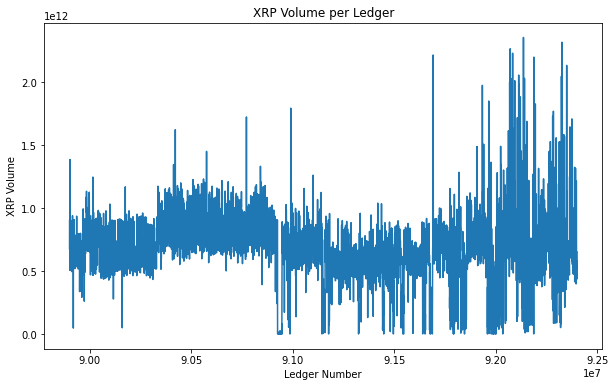

In [9]:
df_xrp_only_cleaned = df_xrp_only_cleaned[df_xrp_only_cleaned['z_score'].abs() <=40]

plt.figure(figsize=(10, 6))
plt.plot(df_xrp_only_cleaned['Ledger_Number'], df_xrp_only_cleaned['XRP_Amount'])

plt.xlabel('Ledger Number')
plt.ylabel('XRP Volume')
plt.title('XRP Volume per Ledger')

plt.show()

## Findings: No visible relationship, maybe an increase in maximums and variance?
## What about XRP trade amounts in relation to other currencies over 500 block intervals?

In [10]:
df_xrp['XRP_Code_Ratio'] = df_xrp['XRP_Amount'] / df_xrp['Code_Amount']


df_xrp['z_score'] = zscore(df_xrp['XRP_Code_Ratio'], nan_policy='omit')
df_xrp.sort_values(by='z_score', ascending=False).head(10)

,Ledger_Number,Datetime,XRP_Code,XRP_Amount,Trade_Code,Code_Amount,XRP_Code_Ratio,z_score
7244,90145995,2024-08-18T18:39:02.000Z,XRP,1.0,BTC,5.575545e-17,1.793547e+16,221.045112
2013,89966995,2024-08-10T17:26:12.000Z,XRP,1.0,4249547800000000000000000000000000000000,2.201349e-16,4.542669e+15,55.981093
8546,90195995,2024-08-21T00:19:12.000Z,XRP,1.0,XAU,6.152636e-16,1.625320e+15,20.025243
3569,90012995,2024-08-12T18:57:30.000Z,XRP,1.0,BTC,2.030531e-15,4.924820e+14,6.063208
6989,90134995,2024-08-18T06:45:41.000Z,XRP,1.0,ETH,6.424786e-15,1.556472e+14,1.911774
3004,89996495,2024-08-12T01:06:02.000Z,XRP,32.0,BTC,3.001045e-13,1.066295e+14,1.307639
2865,89992495,2024-08-11T20:48:10.000Z,XRP,271991.0,BTC,2.590658e-09,1.049892e+14,1.287422
4674,90051995,2024-08-14T13:13:30.000Z,XRP,155859.0,BTC,1.490857e-09,1.045432e+14,1.281926
3066,89997995,2024-08-12T02:43:11.000Z,XRP,98.0,BTC,9.401000e-13,1.042442e+14,1.278241
2404,89979995,2024-08-11T07:22:30.000Z,XRP,9.0,BTC,8.634232e-14,1.042363e+14,1.278143


In [ ]:
# Omitting outliers because looking for trend, don't care for massive price fluctuations
def remove_outliers_by_code(group):
    group['z_score'] = zscore(group['XRP_Code_Ratio'])
    return group[group['z_score'].abs() <= 3]

df_xrp_cleaned = df_xrp.groupby('Trade_Code', group_keys=False).apply(remove_outliers_by_code)
df_xrp_cleaned.sort_values(by='z_score', ascending=False).head(10)


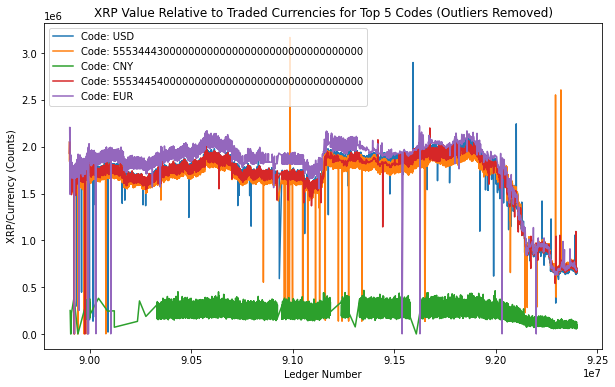

In [18]:
summary = df_xrp_cleaned.groupby('Trade_Code', as_index=False).agg(
    XRP_Sum=('XRP_Amount', 'sum')
)
top_codes = summary.sort_values(by='XRP_Sum', ascending=False).head(5)['Trade_Code']

plt.figure(figsize=(10, 6))

for code in top_codes:
    data = df_xrp_cleaned[df_xrp_cleaned['Trade_Code'] == code]
    plt.plot(data['Ledger_Number'], data['XRP_Code_Ratio'], label=f"Code: {code}")

plt.xlabel('Ledger Number')
plt.ylabel('XRP/Currency (Counts)')
plt.title('XRP Value Relative to Traded Currencies for Top 5 Codes (Outliers Removed)')
plt.legend()

plt.show()


## Apply Loess smoothing

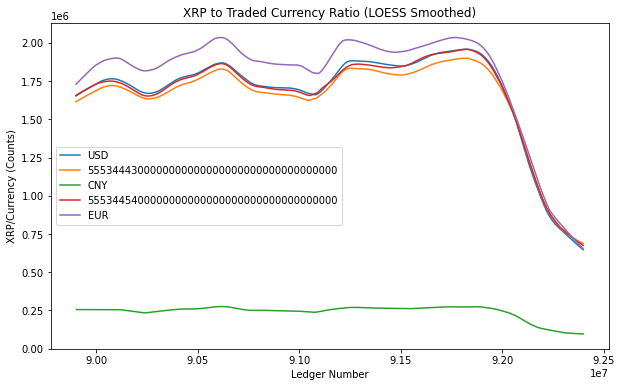

In [ ]:
plt.figure(figsize=(10, 6))

for code in top_codes:
    data = df_xrp_cleaned[df_xrp_cleaned['Trade_Code'] == code]
    
    smoothed = lowess(data['XRP_Code_Ratio'], data['Ledger_Number'], frac=0.2)
        
    plt.plot(smoothed[:, 0], smoothed[:, 1], label=f'{code}')

plt.xlabel('Ledger Number')
plt.ylabel('XRP/Currency (Counts)')
plt.title('XRP to Traded Currency Ratio (LOESS Smoothed)')
plt.legend()

plt.show()

## Gaussian Smoothing

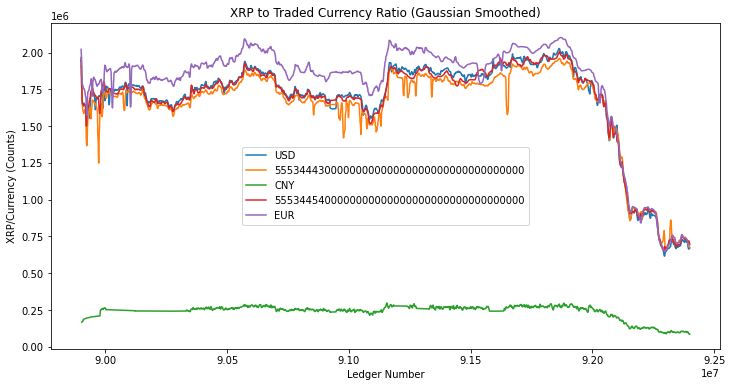

In [16]:
plt.figure(figsize=(12, 6))

for code in top_codes:
    data = df_xrp_cleaned[df_xrp_cleaned['Trade_Code'] == code]

    smoothed = gaussian_filter1d(data['XRP_Code_Ratio'], sigma=5)
        
    plt.plot(data['Ledger_Number'], smoothed, label=f'{code}')

plt.xlabel('Ledger Number')
plt.ylabel('XRP/Currency (Counts)')
plt.title('XRP to Traded Currency Ratio (Gaussian Smoothed)')
plt.legend()

plt.show()


## LOESS model provides a much smoother/more readable output

## Compare ratio fluctuations with price of currency at the dates of these ledgers

In [22]:
# Find min and max dates
min_date = df_xrp_cleaned['Datetime'].min()
max_date = df_xrp_cleaned['Datetime'].max()
print(min_date, max_date)

2024-08-07T17:14:31.000Z 2024-11-27T23:14:50.000Z
